![ADEO Logo](ADEO.jpg)
# Data Science Technical Assessment


#### World Happiness Report 2021 (Nasser AlKhazraji)

<br><br>

**Table of Contents**
1. [Data Cleaning](#Data-Cleaning)
  - [Imputing Missing Values](#Imputation)
2. [KMeans Clustering](#KMeans-Clustering)
  - [Statistical Testing of Clusters using ANOVA](#ANOVA)
  - [Happiness Factor Distributions by Clusters](#Distributions)
3. [Shifts in Happiness over 10 Years](#Shifts)
4. [World Map Visualization](#Choropleth)
5. [Effects of Temperature on Happiness](#Temperature)
6. [Predicting Happiness](#Modelling)
  - [Hyperparameter Tuning](#Hyperparameter-Tuning)
  - [Model Evaluation](#Metrics)
  
  
<br>

<b>Note:</b> Click the `...` to expand the code cell & the `blue sidebar` on the left to collapse it again.

<a id='Data-Cleaning'></a>

## 1) Data Cleaning

In [1]:
import pandas as pd

from sklearn.cluster import KMeans
import plotly.graph_objects as go
import pandas as pd
import emoji
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.formula.api import ols


import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

In [2]:
current_df = pd.read_csv("data/world-happiness-report-2021.csv")
current_df = current_df.iloc[:,[0,1,2,6,7,8,9,10,11]]
current_df['Year'] = 2021

historical_df = pd.read_csv("data/world-happiness-report.csv")
region_mapping = current_df[['Country name', 'Regional indicator']]
historical_df = pd.merge(region_mapping, historical_df.iloc[:,0:9], on='Country name', how='left')
col = historical_df.pop('year')
historical_df.insert(historical_df.shape[1], col.name, col)
historical_df.columns = current_df.columns
merged_df = pd.concat([historical_df, current_df], axis=0)

<a id='Imputation'></a>

#### Imputing Missing Values

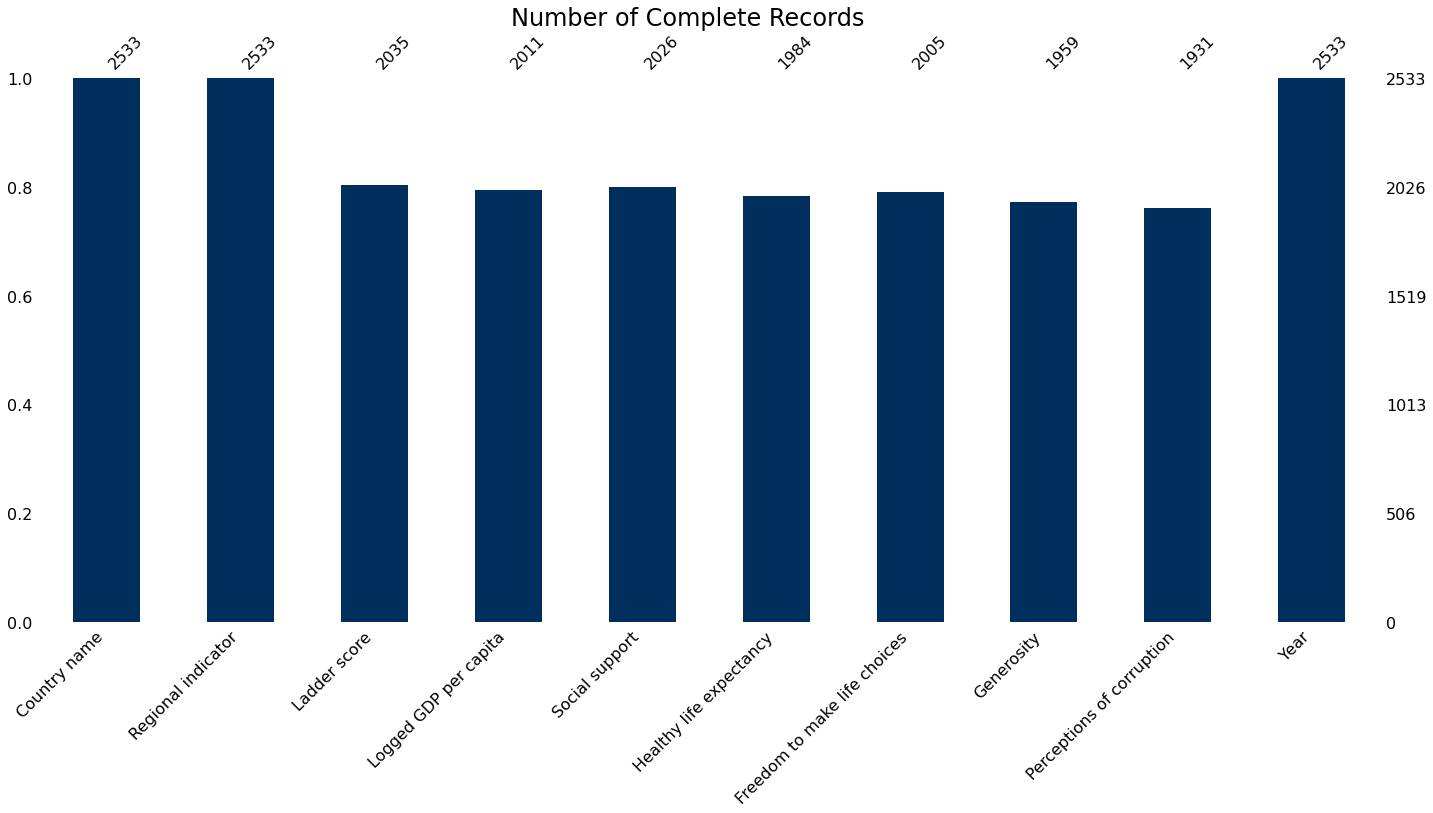

In [3]:
missing = pd.read_csv("data/missing-records.csv")
msno.bar(missing, color='#002E5D')
plt.suptitle("Number of Complete Records", fontsize=24)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
factors_list = merged_df.columns
missing_df = pd.DataFrame()
imputed_df = merged_df[['Country name', 'Regional indicator','Year']]

for i in range(merged_df.shape[1]-3):
    pivot_df = merged_df.set_index(['Country name', 'Year']).iloc[:,i+1].unstack().reset_index()
    missing_df = pd.concat([missing_df, pivot_df.isnull().sum()], axis=1)
    pivot_df.set_index('Country name', drop=True, inplace=True)
    pivot_df = pivot_df.transpose()
    pivot_df.fillna(pivot_df.mean(), inplace=True)
    pivot_df['Year'] = pivot_df.index
    pivot_df = pivot_df.melt(id_vars=['Year'])
    imputed_df = pd.merge(imputed_df, pivot_df, on=['Country name', 'Year'], how='outer')

col = imputed_df.pop('Year')
imputed_df.insert(imputed_df.shape[1], col.name, col)
imputed_df.columns = factors_list
missing_df.columns = factors_list[2:9]
missing_df = missing_df.iloc[1:,]

imputed_df.drop(['Regional indicator'], axis=1, inplace=True)
imputed_df = pd.merge(region_mapping, imputed_df.iloc[:,0:9], on='Country name', how='outer')

<a id='KMeans-Clustering'></a> 

## 2) KMeans Clustering
Determining Optimal K using the Elbow method

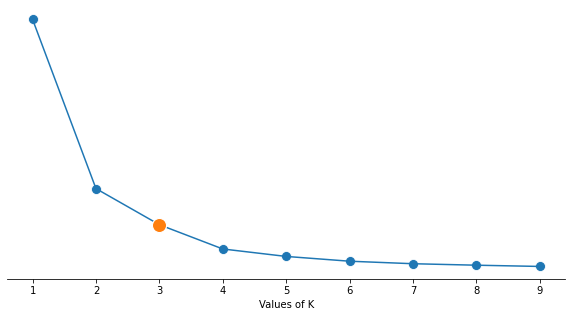

In [5]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(current_df[['Ladder score']])
    distortions.append(kmeanModel.inertia_)
    
fig = plt.gcf()
fig.set_size_inches(10, 5)
g = sns.lineplot(x=K, y=distortions)
g = sns.scatterplot(x=K, y=distortions, s=100)
g = sns.scatterplot(x=[K[2]], y=[distortions[2]], s=200, markers='+', zorder=3)
sns.despine(left=True)
g.set_ylabel('')
g.set_xlabel('Values of K')
g.set(yticks=[])

plt.show()

In [6]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(current_df[['Ladder score']])
current_df.loc[:,'kmean group'] = kmeanModel.labels_

group_labels = current_df[['Ladder score', 'kmean group']].groupby(['kmean group']).agg(['mean'])
group_labels.columns = group_labels.columns.get_level_values(0)

group_labels['Status'] = 'Content'
group_labels.iloc[group_labels['Ladder score'].idxmax(),1] = 'Happy'
group_labels.iloc[group_labels['Ladder score'].idxmin(),1] = 'Unhappy'
group_labels.drop(['Ladder score'], axis=1, inplace=True)
group_labels.reset_index(inplace=True)

group_labels = pd.merge(current_df[['Country name', 'kmean group']], group_labels, on='kmean group')
imputed_df = pd.merge(imputed_df, group_labels, on='Country name', how='left')

# Save final dataset for analysis
imputed_df.to_csv("data/imputed-data.csv", index=False)

<a id='ANOVA'></a>

#### Statistical Testing of Clusters using ANOVA

In [7]:
df = pd.read_csv('data/imputed-data.csv')
df = df.iloc[:, [2,3,4,5,6,7,8,10]]
original_cols = list(df.columns)[0:-1]
df.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'group']
factors = df.columns[0:-1]
pvals = []
for i in factors:
    model_string = f'{i} ~ C(group)'
    model = ols(model_string, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    pvals.append(anova_table.iloc[0,3])

summary_anova = pd.DataFrame([pvals], columns=original_cols)
summary_anova.index = ['p-value']
summary_anova

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
p-value,0.0,0.0,4.514384e-256,8.174810e-320,3.714849e-121,2.645818e-16,1.784873e-98


<a id='Distributions'></a>

#### Happiness Factor Distributions by Clusters

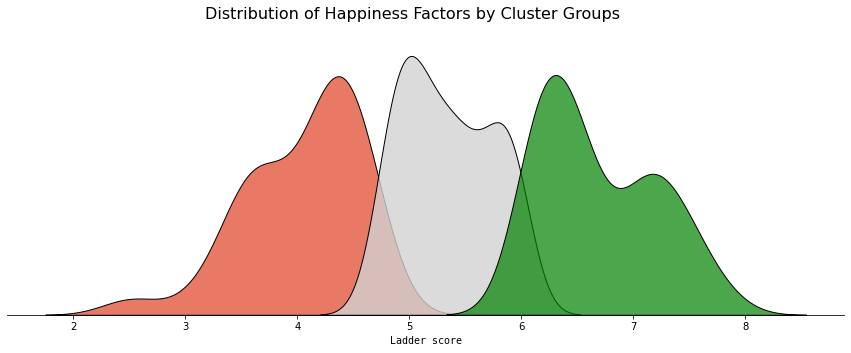

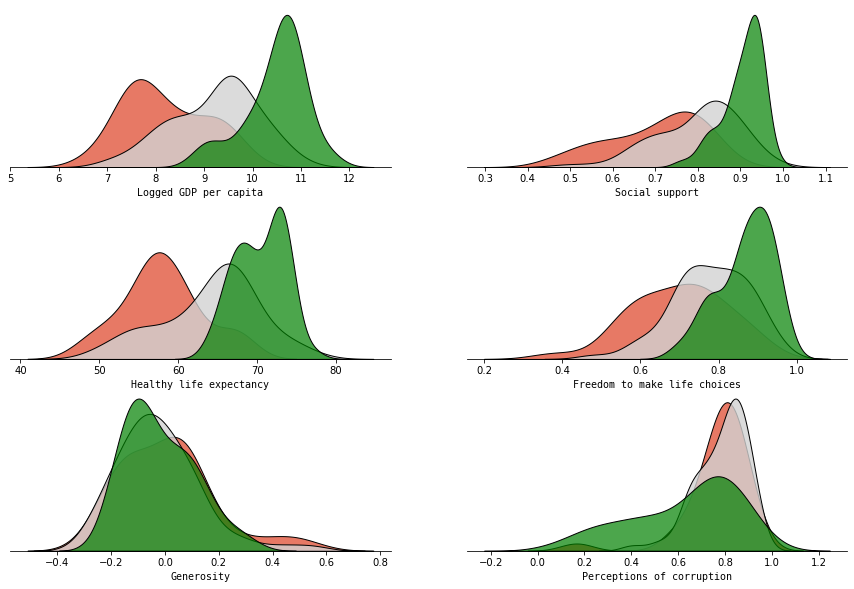

In [8]:
df = pd.read_csv("data/imputed-data.csv")
df['Year'] = df['Year'].astype('int')
current_df = df[df['Year'] == 2021].copy(deep=True)
happy_countries = current_df[current_df['Status'] == 'Happy']
unhappy_countries = current_df[current_df['Status'] == 'Unhappy']
content_countries = current_df[current_df['Status'] == 'Content']

factors = ['Logged GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']


fig = plt.gcf()
fig.set_size_inches(15, 5)
variable = 'Ladder score'
g = sns.kdeplot(unhappy_countries[variable], alpha=0.7, shade=True, ec='black',  color='#dd4124')
g = sns.kdeplot(content_countries[variable], alpha=0.8, shade=True, ec='black',  color='#d2d2d2')
g = sns.kdeplot(happy_countries[variable], alpha=0.7, shade=True, ec='black', color='#008000')
g.set_xlabel(variable, fontfamily='Monospace')
sns.despine(left=True)
g.set_ylabel('')
g.set(yticks=[])
plt.suptitle('Distribution of Happiness Factors by Cluster Groups',fontsize=16)
plt.show()



fig, axes = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(15, 10)

for i, ax in zip(range(10), axes.flat):
    variable = factors[i]
    g = sns.kdeplot(unhappy_countries[variable], alpha=0.7, shade=True, ec='black', ax=ax, color='#dd4124')
    g = sns.kdeplot(content_countries[variable], alpha=0.8, shade=True, ec='black', ax=ax, color='#d2d2d2')
    g = sns.kdeplot(happy_countries[variable], alpha=0.7, shade=True, ec='black', ax=ax, color='#008000')
    g.set_xlabel(variable, fontfamily='Monospace')
    sns.despine(left=True)
    g.set_ylabel('')
    g.set(yticks=[])
    
plt.show()




<a id='Shifts'></a>

## 3) Shifts in Happiness over 10 years

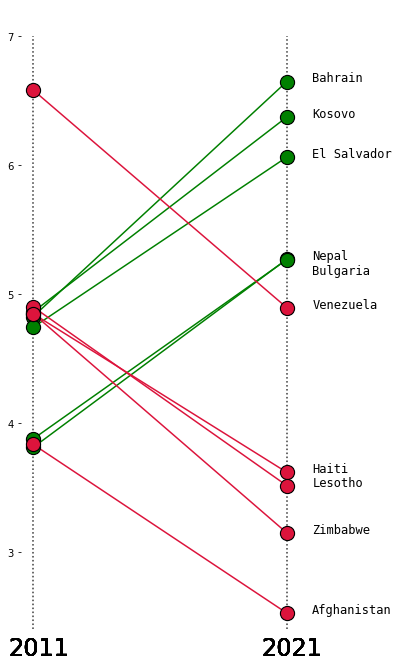

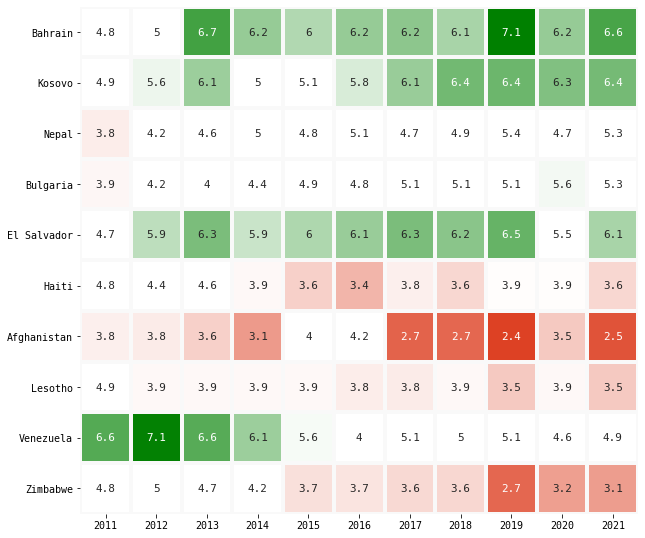

In [9]:
df = pd.read_csv("data/imputed-data.csv")
df['Year'] = df['Year'].astype('int')

ten_year_history = df[(df['Year'] == 2011) | (df['Year'] == 2021)][['Country name', 'Ladder score', 'Year']].copy(deep=True)
ten_year_history = ten_year_history.pivot_table(index=['Country name'], values=['Ladder score'], columns=['Year'])
ten_year_history.columns = ['Historic', 'Current']

ten_year_history['Score change'] = ten_year_history['Current'] - ten_year_history['Historic']
ten_year_history.sort_values(by=['Score change'], axis=0, ascending=False, inplace=True)
ten_year_history = pd.concat([ten_year_history.head(5), ten_year_history.tail(5)])
ten_year_history['Country name'] = ten_year_history.index
ten_year_history['Slope color'] = (ten_year_history['Score change'] < 0)*1

fig = plt.gcf()
fig.set_size_inches(5, 12)

slope_color = ['#008000']*5 + ['#DC143C']*5

for i in range(ten_year_history.shape[0]):
    country = ten_year_history.iloc[i,:]
        
    g = sns.lineplot(x=[1,2], y=[country['Historic'], country['Current']], color=slope_color[i], zorder=2)
    g = sns.scatterplot(x=[1,2], y=[country['Historic'], country['Current']], color=slope_color[i], s=200, edgecolor="black", zorder=3)
    
    if country['Country name'] == 'Bulgaria':
        plt.text(2.1, 5.15, country['Country name'], fontsize='large', fontfamily='monospace')
    
    else:
        plt.text(2.1, country['Current'], country['Country name'],  fontsize='large', fontfamily='monospace')

    plt.plot([2.0, 2.0], [2.4, 7], ':', color='black', alpha=0.1, zorder=1)
    plt.plot([1.0, 1.0], [2.4, 7], ':', color='black', alpha=0.1, zorder=1)
        
    plt.text(0.9,2.2, '2011', fontsize=24)
    plt.text(1.9,2.2,'2021',  fontsize=24)
        
    sns.despine(top=True, bottom=True, left=True, right=True)
    g.set(xticks=[])
    
plt.show()

ten_year_full = df[df['Country name'].isin(ten_year_history['Country name'])][['Country name', 'Year', 'Ladder score']].copy(deep=True)
ten_year_full = ten_year_full[ten_year_full['Year'] >= 2011]
ten_year_full = ten_year_full.pivot_table(index=['Country name'], columns='Year', values='Ladder score')
ten_year_full = ten_year_full.reindex(list(ten_year_history.index))


fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.rcParams["font.family"] = "monospace"


colors = ['#dd4124','white','white','#008000']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

g = sns.heatmap(ten_year_full,
                square=True,
                cmap=cmap,
                linewidth=3,
                linecolor='#f9f9f9',
                cbar=False,
                annot=True,annot_kws={"size": 11})

g.set_ylabel("")
g.set_xlabel("")

plt.show()

<a id='Choropleth'></a>

## 4) World Map Visualization

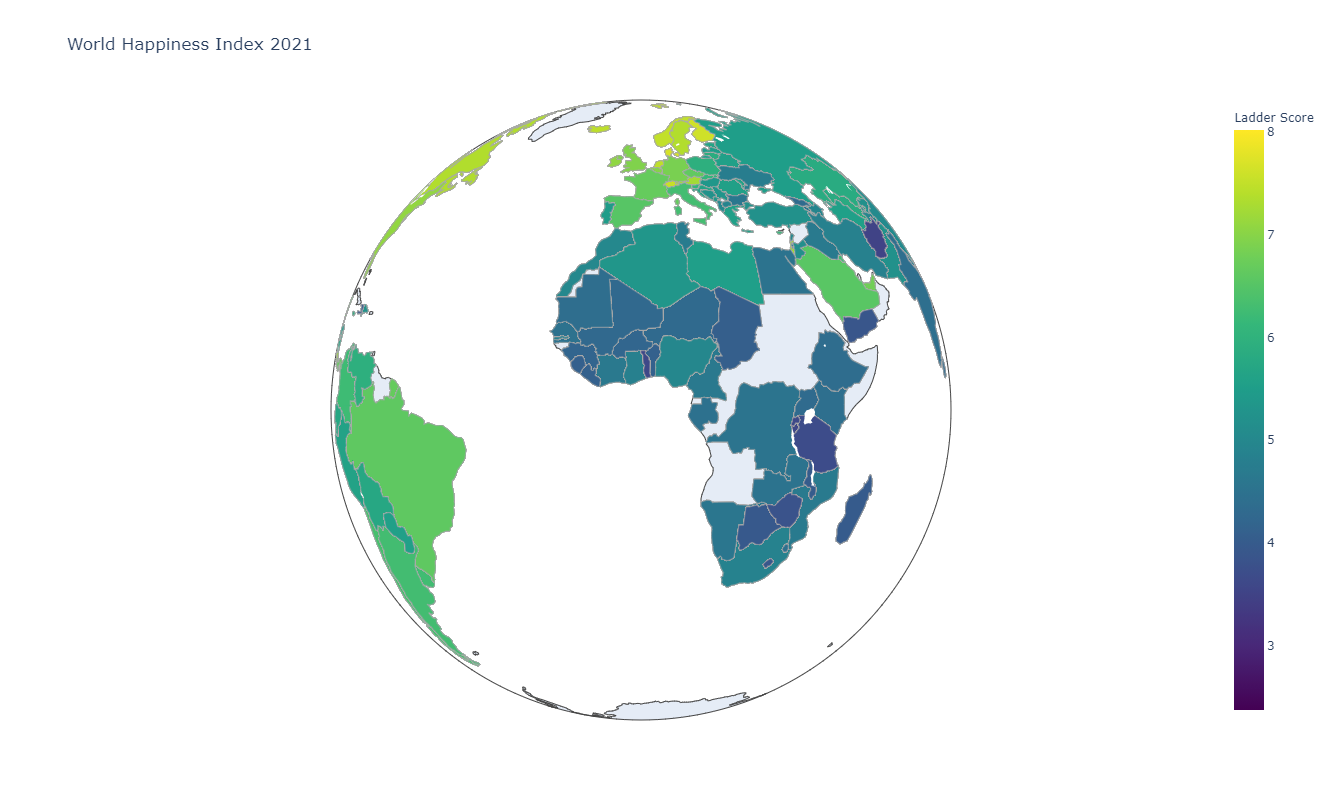

In [10]:
init_notebook_mode(connected=True)
cf.go_offline()

df = pd.read_csv("data/imputed-data.csv")
df['Year'] = df['Year'].astype('int')
country_codes = pd.read_csv("data/country-codes.csv", encoding='ISO-8859-1')
maps_df = pd.merge(country_codes, df, on='Country name', how='right')

# Drop North Cyprus
maps_df = maps_df[maps_df['Country name'] != 'North Cyprus']
maps_df.tail()

maps_df['Emoji'] = maps_df['Status']
emoji_dict = {'Happy': ":grinning_face_with_big_eyes:", 
              'Content': ":neutral_face:",
             'Unhappy': ":sad_but_relieved_face:"}

maps_df.replace({"Emoji": emoji_dict}, inplace=True)

country_texts = []
for i in range(maps_df.shape[0]):
    country = maps_df.iloc[i,:]
    text_annot = f"""
    <b>{country['Country name']}</b> {emoji.emojize(country['Emoji'])}<br>
    Happiness Score: {country['Ladder score']:.2f} <br> <br>
       <i>GDP per Capita</i>: {country['Logged GDP per capita']:.2f} <br>
       <i>Social Support</i>: {country['Social support']:.2f} <br>
       <i>Life Expectancy</i>: {country['Healthy life expectancy']:.2f} <br>
       <i>Generosity</i>: {country['Generosity']:.2f} <br>
       <i>Corruption</i>: {country['Perceptions of corruption']:.2f}
    """
    country_texts.append(text_annot)
    
maps_df['text'] = country_texts

fig = go.Figure(data=go.Choropleth(
    locations = maps_df['Code'],
    locationmode='ISO-3',
    z = maps_df['Ladder score'],
    text = maps_df['text'],
    colorscale = 'Viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Ladder Score',
    hoverinfo='text',
))

fig.update_layout(
    title_text='World Happiness Index 2021',
    autosize=False,
    width=900,
    height=800,
    hoverlabel=dict(
        font_family="monospace",
        ),
    geo=dict(
        showframe=True,
        showcoastlines=True,
        projection_type='orthographic'
    ))

<a id='Temperature'></a>

## 5) Effects of Temperature on Happiness

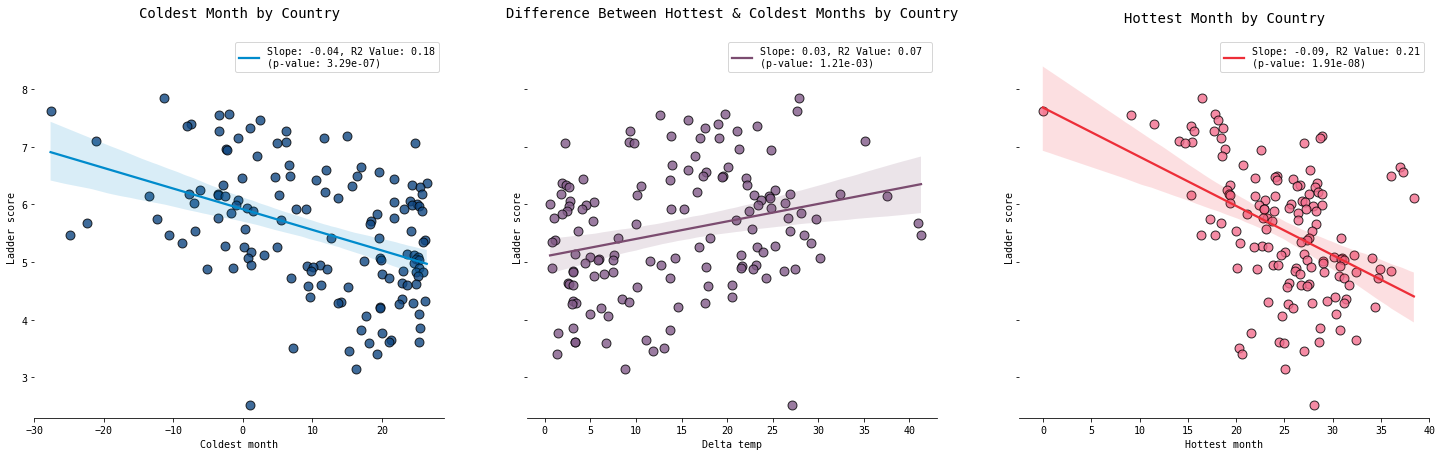

In [11]:
monthly_df = pd.read_csv("data/GlobalLandTemperaturesByCountry.csv")
monthly_df = monthly_df[['dt', 'AverageTemperature', 'Country']]
monthly_df['month'] = pd.DatetimeIndex(monthly_df['dt']).month
monthly_df = monthly_df[monthly_df['dt'] > '2011-01-01']

temp_avg = monthly_df.groupby(by=['Country','month']).mean(['AverageTemperature'])
temp_avg = temp_avg.pivot_table(index='Country', columns='month', values='AverageTemperature')
temp_avg['Hottest month'] = temp_avg.max(axis=1)
temp_avg['Coldest month'] = temp_avg.min(axis=1)
temp_avg['Delta temp'] = temp_avg.max(axis=1) - temp_avg.min(axis=1)
temp_avg['Country name'] = temp_avg.index

df = pd.read_csv("data/imputed-data.csv")
df['Year'] = df['Year'].astype('int')
current_df = df[df['Year'] == 2021].copy(deep=True)
temp_df = pd.merge(current_df, temp_avg[['Country name', 'Hottest month', 'Coldest month', 'Delta temp']], on='Country name', how='left')
temp_df.dropna(axis=0, inplace=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25,7),sharey=True)


slope, intercept, r_value, p_value, std_err = linregress(temp_df['Coldest month'], temp_df['Ladder score'])
ax = sns.regplot(data=temp_df, x='Coldest month', y='Ladder score', scatter_kws=dict(color='#0F4681', s=80, edgecolor='black'), ax=ax1,
            line_kws=dict({'label':f'Slope: {slope:.2f}, R2 Value: {r_value**2:.2f}\n(p-value: {p_value:.2e})'}, color='#008BCC'))
ax.set_title("Coldest Month by Country", fontsize=14, fontfamily='monospace', pad=20)
ax.legend()
ax.set_ylim(2.3, 8.9)
ax.set_xlim(-30, 29)
sns.despine(left=True)

slope, intercept, r_value, p_value, std_err = linregress(temp_df['Delta temp'], temp_df['Ladder score'])
ax = sns.regplot(data=temp_df, x='Delta temp', y='Ladder score', scatter_kws=dict(color='#815A88', s=80, edgecolor='black'), ax=ax2,
            line_kws=dict({'label':f'Slope: {slope:.2f}, R2 Value: {r_value**2:.2f} \n(p-value: {p_value:.2e})'}, color='#7B4C70'))
ax.set_title("Difference Between Hottest & Coldest Months by Country", fontsize=14, fontfamily='monospace', pad=20)
ax.legend()
ax.set_ylim(2.3, 8.9)
ax.set_xlim(-2, 43)
sns.despine(left=True)


slope, intercept, r_value, p_value, std_err = linregress(temp_df['Hottest month'], temp_df['Ladder score'])

ax = sns.regplot(data=temp_df, x='Hottest month', y='Ladder score', scatter_kws=dict(color='#f36e8e', s=80, edgecolor='black'), ax=ax3,
            line_kws=dict({'label':f'Slope: {slope:.2f}, R2 Value: {r_value**2:.2f}\n(p-value: {p_value:.2e})'}, color='#ED2E38'))
ax.set_title("Hottest Month by Country", fontsize=14, fontfamily='monospace', pad=15)
ax.legend()
ax.set_ylim(2.3, 8.9)
ax.set_xlim(-2.5, 40)
sns.despine(left=True)

<a id='Modelling'></a>

## 6) Predicting Happiness

#### Splitting the data

In [12]:
df = pd.read_csv("data/imputed-data.csv")
df.drop(['kmean group', 'Status'], axis=1, inplace=True)
df['Year'] = df['Year'].astype('int')

model_df = df.copy(deep=True)
model_df['Country name'] = pd.factorize(model_df['Country name'])[0]
model_df['Regional indicator'] = pd.factorize(model_df['Regional indicator'])[0]

X_train, test, y_train, test_y = train_test_split(model_df.drop(['Ladder score'], axis=1), model_df['Ladder score'], test_size=0.2, random_state=1234)
train, val, train_y, val_y = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

cv_train = model_df.copy(deep=True)
cv_train_y = model_df['Ladder score']
cv_train.drop(['Ladder score'], axis=1, inplace=True)

<a id='Hyperparameter-Tuning'></a>

#### Hyperparameter Tuning
* Parameters are hard coded to reduce computational load for this notebook
* Parameters are not optimal values, but rather included in this section as proof-of-concept
* Given a need for a more accurate predictive regression model, optimal parameters would have been selected

In [13]:
def XGBoost_Tuning(train, train_y):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error',
                           cv = 5,
                           n_jobs = -1,
                           verbose = False)
    
    gsearch.fit(train,train_y)

    return gsearch.best_params_

# Hard-coded XGBoost parameters
xgb_tuned_params = {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.7}
# xgb_tuned_params = XGBoost_Tuning(train, train_y) 

tuned_xgb = XGBRegressor(**xgb_tuned_params)
tuned_xgb.fit(train, train_y)
tuned_xgb_preds = tuned_xgb.predict(test)

def LightGBM_Tuning(train, train_y):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 60, 100],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500]
    }

    lgb_model = LGBMRegressor()

    gsearch = GridSearchCV(estimator = lgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error',
                           cv = 5,
                           n_jobs = -1,
                           verbose = False)
    
    gsearch.fit(train,train_y)

    return gsearch.best_params_


# Hard-coded XGBoost parameters
lgb_tuned_params = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 60, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5}
# lgb_tuned_params = LightGBM_Tuning(train, train_y)

tuned_lgb = LGBMRegressor(**lgb_tuned_params)
tuned_lgb.fit(train, train_y)
tuned_lgb_preds = tuned_lgb.predict(test)

#### CV & Test Set Scores

In [14]:
models = [LinearRegression(), Ridge(), SVR(), XGBRegressor(), XGBRegressor(**xgb_tuned_params), LGBMRegressor(), LGBMRegressor(**lgb_tuned_params)]
model_name = ['LR', 'Ridge', 'SVM', 'XGBoost', 'Tuned XGBoost','LightGBM',  'Tuned LightGBM']
test_model_summary = []

for i in range(len(models)):
    model = models[i]
    cv_scores = cross_val_score(model, cv_train, cv_train_y, cv=10, scoring = 'neg_mean_absolute_error')
    cv_mae = abs(cv_scores).mean()

    model.fit(train, train_y)
    preds = model.predict(test)
    tts_mae = mean_absolute_error(test_y, preds)
    
    model_score = pd.DataFrame([model_name[i], cv_mae, tts_mae]).transpose()
    test_model_summary.append(model_score)
    
test_model_summary = pd.concat(test_model_summary)
test_model_summary.reset_index(inplace=True, drop=True)
test_model_summary.columns = ['Model', 'CV Score', 'Test Set Score']

#### Validation Set Scores

In [15]:
final_train = train.append(test)
final_train_y = train_y.append(test_y)

val_model_summary = []
for i in range(len(models)):
    model = models[i]
    model.fit(final_train, final_train_y)
    preds = model.predict(val)
    tts_mae = mean_absolute_error(val_y, preds)
    
    model_score = pd.DataFrame([model_name[i], tts_mae]).transpose()
    val_model_summary.append(model_score)
    
val_model_summary = pd.concat(val_model_summary)
val_model_summary.reset_index(inplace=True, drop=True)
val_model_summary.columns = ['Model', 'Validation Set Score']
model_table = pd.merge(test_model_summary, val_model_summary, on='Model')

#### Ensemble Model Scores 
* Note: Ensemble model used a weighted average of untuned LightGBM and XGBoost models, producing a more accurate result than either individually

In [16]:
lgb_model = LGBMRegressor()
xgb_model = XGBRegressor()

lgb_model.fit(train, train_y)
lgb_preds = lgb_model.predict(test)

xgb_model.fit(train, train_y)
xgb_preds = xgb_model.predict(test)

ensemble_preds = (lgb_preds*0.5) + (xgb_preds*0.5)
test_ensemble_score = mean_absolute_error(test_y, ensemble_preds)

lgb_model.fit(final_train, final_train_y)
lgb_preds = lgb_model.predict(val)

xgb_model.fit(final_train, final_train_y)
xgb_preds = xgb_model.predict(val)

ensemble_preds = (lgb_preds*0.5) + (xgb_preds*0.5)
val_ensemble_score = mean_absolute_error(val_y, ensemble_preds)

ensemble_summary = pd.DataFrame(['Ensemble (Untuned XGBoost + LightGBM)', 'NA', test_ensemble_score, val_ensemble_score]).transpose()
ensemble_summary.columns = ['Model', 'CV Score', 'Test Set Score', 'Validation Set Score']

<a id='Metrics'></a>

#### Model Evaluation

In [17]:
final_model_table = pd.concat([model_table, ensemble_summary], axis=0, ignore_index=True)
final_model_table

,Model,CV Score,Test Set Score,Validation Set Score
0,LR,0.337919,0.293462,0.344255
1,Ridge,0.337984,0.293436,0.343823
2,SVM,0.437695,0.431099,0.440702
3,XGBoost,0.359812,0.207848,0.228388
4,Tuned XGBoost,0.350024,0.199123,0.220393
5,LightGBM,0.350588,0.201355,0.220094
6,Tuned LightGBM,0.374846,0.20397,0.229669
7,Ensemble (Untuned XGBoost + LightGBM),NA,0.198037,0.218025
